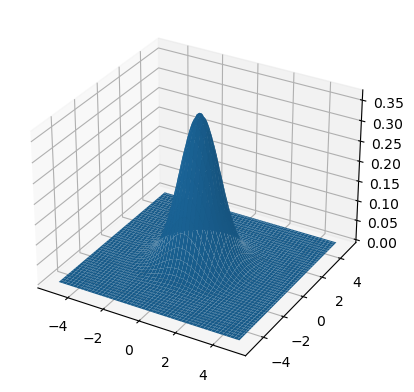

In [180]:
# define a 2d gaussian function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


#define a 2d gaussian function that decays exponentially as a function of time
def gaussian_t(x, y, x0, y0, sigma, t, decayConstant=1):
    return np.exp(-((x-x0)**2 + (y-y0)**2)/(2*sigma**2)) * np.exp(-decayConstant*t)

# define a grid between -5 and 5 (representing km)
x = np.linspace(-5, 5, 100)

# create a meshgrid
X, Y = np.meshgrid(x, x)

# create the 2d gaussian
Z = gaussian_t(X, Y, 0, 0, 1, 1)

# plot the 2d gaussian
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()


In [183]:
initial_uncertainty = 0.2 #200 meters
minimum_uncertainty = 0.05 #50 meters
meas_uncertainty = 0.01
n_detectors = 100
n_time_samples = 50

# create a list of n_samples random x and y values within the range -5 to 5
x_test = np.random.uniform(-5, 5, n_detectors)
y_test = np.random.uniform(-5, 5, n_detectors)

# sample the 2d gaussian at these x and y values for each time sample assuming they are sampled as a batch with a time step of 1
z_test = np.array([gaussian_t(x_test, y_test, 0, 0, 1, t, 0.1) for t in range(n_time_samples)])

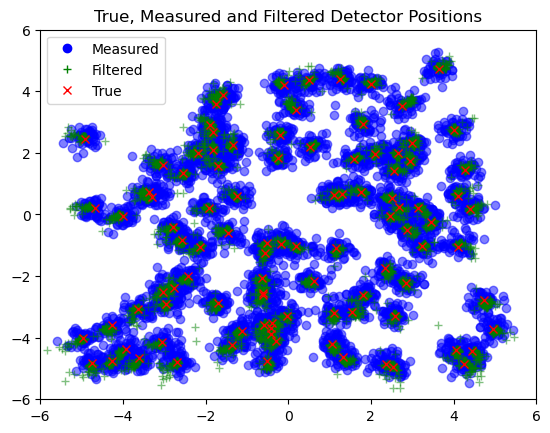

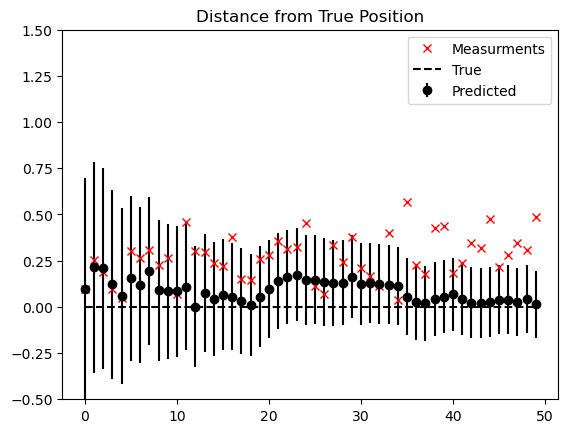

In [202]:
from filterpy.kalman import KalmanFilter
import numpy as np

pos_uncertainty = 0.200 #200 meters
#create position measurements with noise
x_random = x_test.reshape(1, n_detectors) + np.random.normal(0, pos_uncertainty, (n_time_samples, n_detectors))
y_random = y_test.reshape(1, n_detectors) + np.random.normal(0, pos_uncertainty, (n_time_samples, n_detectors))

#initialize the kalman filters
filters = []
for _ in range(n_detectors):
    f = KalmanFilter(dim_x=4, dim_z=2)
    f.x = np.array([x_random[0,0], y_random[0,0], 0, 0])
    f.F = np.array([[1, 0, 1, 0],
                    [0, 1, 0, 1],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])
    f.H = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0]])
    #f.P *= 1000
    # Define the measurement noise covariance
    f.R = np.eye(2) * 0.2 # Measurement noise - this should be near what is expiemntally measured, estimated to be 200 meters

    # Define the process noise covariance
    f.Q = np.eye(4) * 1e-6  # Process noise - static placement, so this is low

    filters.append(f)

#initialize the filtered positions
filtered_positions = []
filter_uncertainty = []

#iterate through the time samples
for t in range(n_time_samples):
    #iterate through the detectors
    for i in range(n_detectors):
        #predict the position
        filters[i].predict()
        #update the position with the measurement
        filters[i].update(np.array([x_random[t, i], y_random[t, i]]))
        #append the filtered position to the list
        filtered_positions.append(filters[i].x)
        #append the calculated uncertainty to the list as a tuple
        filter_uncertainty.append( [np.sqrt(filters[i].P[0, 0]), np.sqrt(filters[i].P[1, 1])] )

filtered_positions = np.array(filtered_positions).reshape(n_time_samples, n_detectors, 4)
filter_uncertainty = np.array(filter_uncertainty).reshape(n_time_samples, n_detectors, 2)
x_uncertainty = filter_uncertainty[:, :, 0]
y_uncertainty = filter_uncertainty[:, :, 1]


# plot the original and filtered x and y positions
plt.plot(x_random, y_random, 'bo', alpha=0.5)
#plot the filtered position as a green +
plt.plot(filtered_positions[:, :, 0], filtered_positions[:, :, 1], 'g+', alpha=0.5)
#plot the true position as a red x
plt.plot(x_test, y_test, 'rx')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.legend(handles=[plt.Line2D([], [], marker='o', color='b', linestyle='None', markerfacecolor='b', label='Measured'),
                    plt.Line2D([], [], marker='+', color='g', linestyle='None', markerfacecolor='g', label='Filtered'),
                    plt.Line2D([], [], marker='x', color='r', linestyle='None', markerfacecolor='r', label='True')])
plt.title('True, Measured and Filtered Detector Positions')
plt.show()

#plot the estimated distance from the true position for all single detectors along with the uncertainty as error bars
for i in range(1):
    distance = np.sqrt((filtered_positions[:, i, 0] - x_test[i])**2 + (filtered_positions[:, i, 1] - y_test[i])**2)
    uncertainty = np.sqrt(x_uncertainty[:,i]**2 + y_uncertainty[:,i]**2)
    plt.errorbar(range(n_time_samples), distance, yerr=uncertainty, fmt='o', color='k')

    #plot the measured distance from the true position for all single detectors
    distance = np.sqrt((x_random[:, i] - x_test[i])**2 + (y_random[:, i] - y_test[i])**2)
    plt.plot(range(n_time_samples), distance, 'x', color='r')

#plot a horizontal dashed line at 0
plt.plot(range(n_time_samples), np.zeros(n_time_samples), 'k--')

#describe the x and circle markers
plt.legend(['Measurments', 'True', 'Predicted'])
plt.title('Distance from True Position')
plt.ylim(-0.5,1.5)
plt.show()




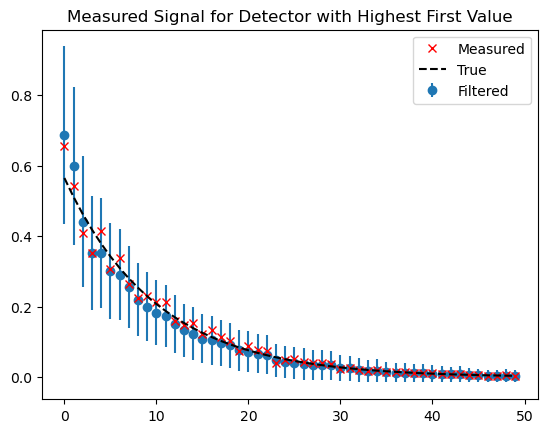

In [304]:
meas_uncertainty = 0.1 # relative uncertainty of 10%
minimum_noise = 0.2
minimum_noise_uncertainty = 0.01
#modify the z's by adding a random number from a normal distribution with a mean of 0 and a standard deviation of 0.1
z_train = z_test + np.random.normal(0, z_test*meas_uncertainty, (n_time_samples, n_detectors)) + minimum_noise*np.random.normal(0, minimum_noise_uncertainty, (n_time_samples, n_detectors))

#ensuer that the measured values are positive
z_train = np.abs(z_train)

#initialize the kalman filters
decay_filters = []

for d in range(n_detectors):
    f = KalmanFilter(dim_x=2, dim_z=1)
    f.x = np.array([z_test[0,d], 1])
    f.F = np.array([[1, 1],
                    [0, 1]])
    f.H = np.array([[1, 0]])
    f.R = np.array([[meas_uncertainty*z_test[0,d]]])
    decayRate = 0.1
    process_noise_variance = 0.01
    f.Q = np.array([[0, 0],
                    [0, process_noise_variance * decayRate**2]])
    decay_filters.append(f)

#initialize the filtered data
filtered_data = np.zeros((n_time_samples, n_detectors, 2))

for t in range(n_time_samples):
    for d in range(n_detectors):
        decay_filters[d].R = np.array([[meas_uncertainty * z_train[t, d]]])
        decay_filters[d].predict()
        decay_filters[d].update(z_train[t, d])
        filtered_data[t, d, 0] = decay_filters[d].x[0]
        filtered_data[t, d, 1] = np.sqrt(decay_filters[d].P[0, 0])

#plot z_train for the detector with the highest first value
idx = np.argmax(z_train[0, :])
plt.errorbar(range(n_time_samples), filtered_data[:, idx, 0], yerr=filtered_data[:, idx, 1], fmt='o', label='Filtered', zorder=1)
plt.plot(range(n_time_samples), z_train[:, idx], 'x', c='r', label='Measured', zorder=2)
plt.plot(range(n_time_samples), z_test[:, idx], 'k--', label='True', zorder=3)
plt.title('Measured Signal for Detector with Highest First Value')
plt.legend()
plt.show()

In [ ]:
#restructure the data to be a list of tuples ordered by time of information arrival. The detectors transmit thier data, not all at once, or in the same order, but typically every 5 minutes.
# the tuple format should take the form of (time, det_reading, det_unc, x_cal, y_cal, baro)
#where time is the time the data was received, det_reading is the reading from the detector, det_unc is the uncertainty of the reading, x_cal, y_cal are the calculated
# x and y positions of the detector, and baro is the barometric pressure reading. The barometric pressure reading is assumed to be constant for this example.

random_times = np.random.uniform(0, 300, n_time_samples)

data = []
for t in range(n_time_samples):
    for d in range(n_detectors):
        data.append((t, z_train[t, d], filtered_data[t, d, 1], filtered_positions[t, d, 0], filtered_positions[t, d, 1], 1013.25))